In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import vgg16
import utils
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from keras.utils import np_utils

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold as KF

Using TensorFlow backend.


### 处理数据集

In [2]:
data_path = '../../jaffe/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-FEAR

Loaded the images of dataset-SURPRISE

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-DISGUST

Loaded the images of dataset-SAD

Loaded the images of dataset-HAPPY

Loaded the images of dataset-ANGRY



(213, 224, 224, 3)

### 打上 Label

In [3]:
num_classes = 7#生气、厌恶、恐惧、快乐、没啥表情、伤心、吃惊

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:32]=0 #32
labels[32:62]=1 #30
labels[62:92]=2 #30
labels[92:121]=3 #29
labels[121:152]=4 #31
labels[152:183]=5 #31
labels[183:]=6 #30

names = ['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY']

def getLabel(id):
    return ['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY'][id]
Y=labels
Y.shape

(213,)

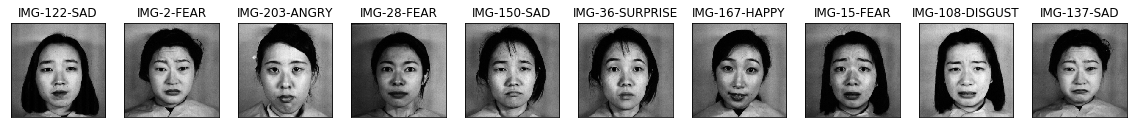

In [4]:
indices = np.random.randint(0, len(img_data)-1, 10)#随机取 10 张图片
for i,im in enumerate(img_data[indices,:,:]):
    plt.subplot(1, len(indices), i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    plt.title('IMG-' + str(indices[i])+"-"+names[labels[indices[i]]])
plt.show()

### 由于 CUDA 的版本不支持，所以下面的特征提取跑在 CPU 上

In [ ]:
batch=img_data
print(batch.shape)
features=[]
i=0
while(i<200):
    with tf.device('/cpu:0'):
        with tf.Session() as sess:
            images = tf.placeholder("float", [20, 224, 224, 3])
            feed_dict = {images: batch[i:i+20]}
            i+=20
            vgg = vgg16.Vgg16()
            with tf.name_scope("content_vgg"):
                vgg.build(images)
            feature = sess.run(vgg.fc7, feed_dict=feed_dict)#提取fc8层的特征

            features.append(feature)

(213, 224, 224, 3)
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 1s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
/home/xionglong/Facial_reg/CNN2ML/tensorflow-vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
/home/xionglong/Facia

In [ ]:
batch=img_data[200:213]
print(batch.shape)
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [13, 224, 224, 3])
        feed_dict = {images: batch}
        vgg = vgg16.Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images)
        feature = sess.run(vgg.fc7, feed_dict=feed_dict)#提取fc8层的特征

        features.append(feature)

In [ ]:
result=[]
for feature in features:
    for item in feature:
        result.append(item)
result=np.array(result)
result.shape

In [ ]:
# import pandas as pd
# df=pd.DataFrame(data=result)
# df.to_csv('./features.csv')

### 划分训练集和测试集

In [ ]:
kf = KF(n_splits=10, shuffle=True).split(result)
train_indices, test_indices =  next(kf)

X_train = result[train_indices]
y_train = labels[train_indices]

X_test = result[test_indices]
y_test = labels[test_indices]

### 训练模型

#### 支持向量机

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
y_predict = lsvc.predict(X_test)

In [ ]:
print('The Accuracy of LinearSVC is:', lsvc.score(X_test, y_test))
print(classification_report(y_test, y_predict, target_names=names))

In [ ]:
for i,im in enumerate(img_data[test_indices[0:10],:,:]):
    plt.subplot(1, 10, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    emotions = np.array(['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY'])
    title = str(emotions[y_predict[i]])
    
    if title == str(emotions[labels[test_indices][i]]):
        plt.title(title, color='green')
    else:
        plt.title(title, color='red')
    plt.xlabel(emotions[labels[test_indices][i]],color='blue')
plt.show()

#### 交叉验证

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
clf = LinearSVC()

scores = cross_val_score(clf, result, labels, cv=9)

In [ ]:
print(scores.mean())

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=1).fit(X_train, y_train)
y_predict = knn.predict(X_test)

# print('Predicted Classes:', y_predict, '\n')
# print('Real Classes:', labels[test_indices], '\n')

print('The Accuracy of KNN is:', knn.score(X_test, y_test))
print(classification_report(y_test, y_predict, target_names=names))

In [ ]:
for i,im in enumerate(img_data[test_indices[0:10],:,:]):
    plt.subplot(1, 10, i+1)
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    emotions = np.array(['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY'])
    title = str(emotions[y_predict[i]])
    
    if title == str(emotions[labels[test_indices][i]]):
        plt.title(title, color='green')
    else:
        plt.title(title, color='red')
    plt.xlabel(emotions[labels[test_indices][i]],color='blue')
plt.show()

#### KNN 交叉验证

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=1)
scores = cross_val_score(knn, result, labels, cv=9)
print(scores.mean())

### 可视化 CNN 中间层

In [ ]:
tf.enable_eager_execution()

def my_model(x):
  return tf.square(x)  # you'd likely have something more sophisticated

print(my_model(3.0)) 

### conv2_ 擅于提取的面部五官特征

In [ ]:
batch=img_data[200:201]
print(batch.shape)
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])
        feed_dict = {images: batch}
        vgg = vgg16.Vgg16()
        with tf.name_scope("content_vgg"):
            vgg.build(images)
        feature_fc8 = sess.run(vgg.conv3_2, feed_dict=feed_dict)#提取fc8层的特征

In [ ]:
feature_fc8.shape

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(feature_fc8[0, :, :, 80], cmap='viridis')
plt.show()